## Prepare the score file from evaluation file

In [13]:
import numpy as np
import glob, os, json
import pandas as pd
# score_path = "/data/mint/TPAMI_evaluations/MP/score/tuning_solver/"

test_on = 'mp_test2'

if test_on == 'mp_test':
    mp_test_difareli = {
        'mean_mse': 0.0122,
        'sd_mse': 0.013,
        'mean_dssim': 0.0711,
        'sd_dssim': 0.0335,
        'mean_lpips': 0.1370,
        'sd_lpips': 0.056
    }
    mp_test_ss = {
        'mean_mse': 0.01078, 
        'sd_mse': 0.011,
        'mean_lpips': 0.1187,
        'sd_lpips': 0.043,
        'mean_dssim': 0.06348,
        'sd_dssim': 0.0285
    }
    ours_test_score = {'ss':mp_test_ss, 'difareli':mp_test_difareli}
    score_path = "/data/mint/TPAMI_evaluations/MP/score/notuning_solver/multipie/mp_test"
elif test_on == 'mp_test2':
    mp_test2_difareli = {
        'mean_dssim': 0.0969,
        'sd_dssim': 0.0485,
        'mean_mse': 0.0215,
        'sd_mse': 0.0227,
        'mean_lpips': 0.1669,
        'sd_lpips': 0.0538
    }
    mp_test2_ss = {
        'mean_mse': 0.02001, 
        'sd_mse': 0.0212,
        'mean_lpips': 0.1361,
        'sd_lpips': 0.0572,
        'mean_dssim': 0.0874,
        'sd_dssim': 0.0461
    }
    ours_test_score = {'ss':mp_test2_ss, 'difareli':mp_test2_difareli}
    score_path = "/data/mint/TPAMI_evaluations/MP/score/notuning_solver/multipie/mp_test2"

score_dict = {
    "dpmsolver" : {
        "steps" : {}
    },
    "dpmsolver++" : {
        "steps" : {}
    },
    "unipc" : {
        "steps" : {}
    }
}

m_sel = 'multistep'
o_sel = 2
metrices = ['mse', 'lpips']
for s in glob.glob(score_path + '/*.json'):
    name = os.path.basename(s).split('.')[0].split('eval_score_')[1]
    solver_name, method, steps, order, _ = name.split('_')
    
    if method == m_sel and int(order) == o_sel:
        with open(s, 'r') as f:
            data = json.load(f)
            # Data example : 0.017334407195448875 +- 0.023438921198248863
            score_dict[solver_name]['steps'][steps] = {}
            for m_type in metrices:
                mean_error, sd_error = data['eval_score'][m_type].split('+-')
                mean_error = float(mean_error)
                sd_error = float(sd_error)
                score_dict[solver_name]['steps'][steps][f'mean_{m_type}'] = mean_error
                score_dict[solver_name]['steps'][steps][f'sd_{m_type}'] = sd_error
                score_dict[solver_name]['steps'][steps]['full_name'] = f'{solver_name}_{order}_{method}_{steps}_None'
                score_dict[solver_name]['steps'][steps]['full_name_tmp'] = name
                
            # Sorted by steps
            score_dict[solver_name]['steps'] = dict(sorted(score_dict[solver_name]['steps'].items(), key=lambda item: int(item[0])))

# Adding DSSIM results
if test_on == 'mp_test':
    dssim_path = "/home/mint/Dev/DiFaReli/difareli-faster/evaluations/results/notuning_solver/mp_test_results.csv"
elif test_on == 'mp_test2':
    dssim_path = "/home/mint/Dev/DiFaReli/difareli-faster/evaluations/results/notuning_solver/mp_test2_results.csv"

df = pd.read_csv(dssim_path, delimiter=',')
dssim_score = list(df['DSSIMScore'].values)
dssim_score = [x.split(' +- ') for x in dssim_score]
dssim_score = np.array(dssim_score).astype(float)
df['mean_dssim'] = dssim_score[:, 0].astype(float)
df['sd_dssim'] = dssim_score[:, 1].astype(float)

for solver_name in score_dict.keys():
    for steps in score_dict[solver_name]['steps'].keys():
        name = score_dict[solver_name]['steps'][str(steps)]['full_name_tmp']
        # Get the data from the dataframe where the name matched
        score_dict[solver_name]['steps'][str(steps)]['mean_dssim'] = df['mean_dssim'][df['MethodName'] == name].values[0]
        score_dict[solver_name]['steps'][str(steps)]['sd_dssim'] = df['sd_dssim'][df['MethodName'] == name].values[0]
        print(solver_name, steps, score_dict[solver_name]['steps'][str(steps)]['mean_dssim'])

dpmsolver 10 0.126351
dpmsolver 20 0.105046
dpmsolver 25 0.098566
dpmsolver 50 0.093048
dpmsolver 75 0.092711
dpmsolver 100 0.092329
dpmsolver++ 10 0.1554
dpmsolver++ 20 0.108673
dpmsolver++ 25 0.100649
dpmsolver++ 50 0.094629
dpmsolver++ 75 0.093976
dpmsolver++ 100 0.093268
unipc 10 0.19947
unipc 20 0.113093
unipc 25 0.106623
unipc 50 0.097539
unipc 75 0.093811
unipc 100 0.092531


## Copying the runtime file first

In [14]:
plot_step = [10, 25, 50, 75, 100]
runtime_path = "/data/mint/sampling/TPAMI/solver_not_tuned_for_runtime"
os.makedirs(runtime_path, exist_ok=True)
# Check empty dir
if len(os.listdir(runtime_path)) == 0:
    # sshfs with read-only mode
    print(f"sshfs -o ro mint@10.204.100.109:{runtime_path} {runtime_path}")
    
model = "log=Masked_Face_woclip+BgNoHead+shadow_256_cfg=Masked_Face_woclip+BgNoHead+shadow_256.yaml"
for solver in score_dict.keys():
    for step in plot_step:
        name = score_dict[solver]['steps'][str(step)]['full_name']
        rp = f'{runtime_path}/{model}_{name}/ema_085000/{test_on}/'
        rf = glob.glob(rp + '/runtime*.json')[0]
        with open(rf, 'r') as f:
            runtime = json.load(f)
        score_dict[solver]['steps'][str(step)]['mean_runtime'] = np.mean(np.array(runtime['rev_time']) + np.array(runtime['relit_time']))
        score_dict[solver]['steps'][str(step)]['sd_runtime'] = np.std(np.array(runtime['rev_time']) + np.array(runtime['relit_time']))
        

runtime_dict = {}
for step in plot_step:
    tmp = []
    for solver in score_dict.keys():
        tmp.append(score_dict[solver]['steps'][str(step)]['mean_runtime'])
    runtime_dict[step] = {'mean_runtime':np.mean(tmp), 'sd_runtime':(np.mean(tmp))}

['1.29', '3.16', '6.18', '9.31', '12.45']


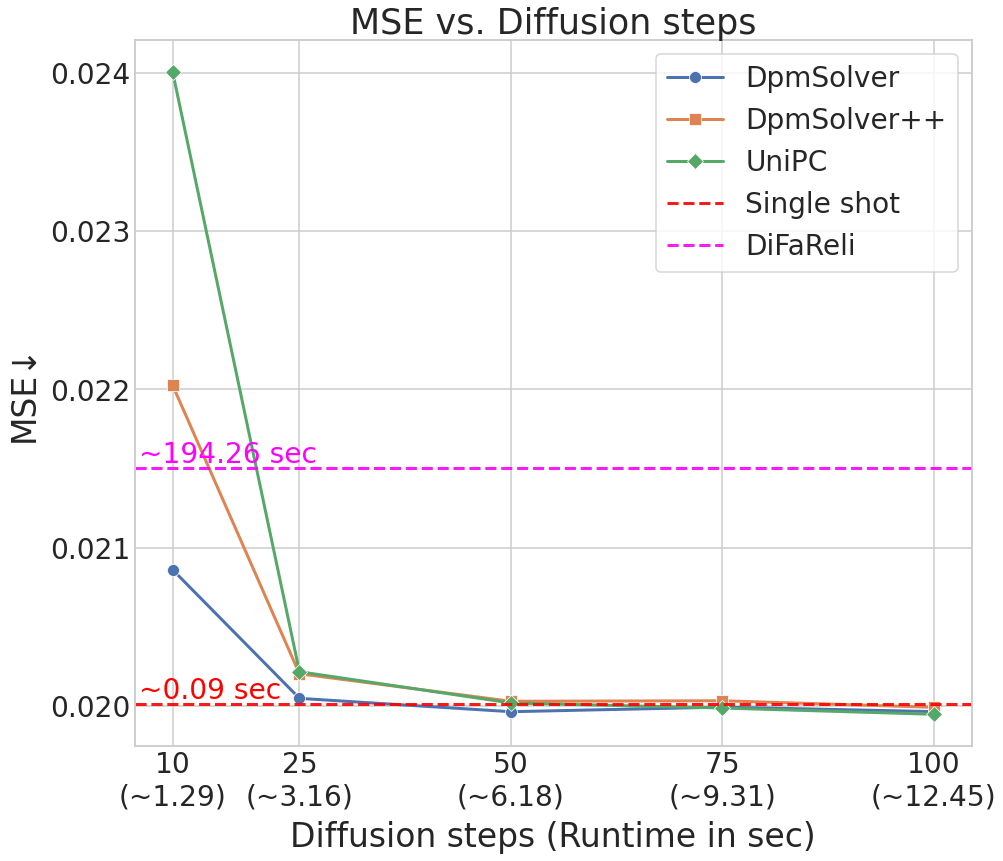

['1.29', '3.16', '6.18', '9.31', '12.45']


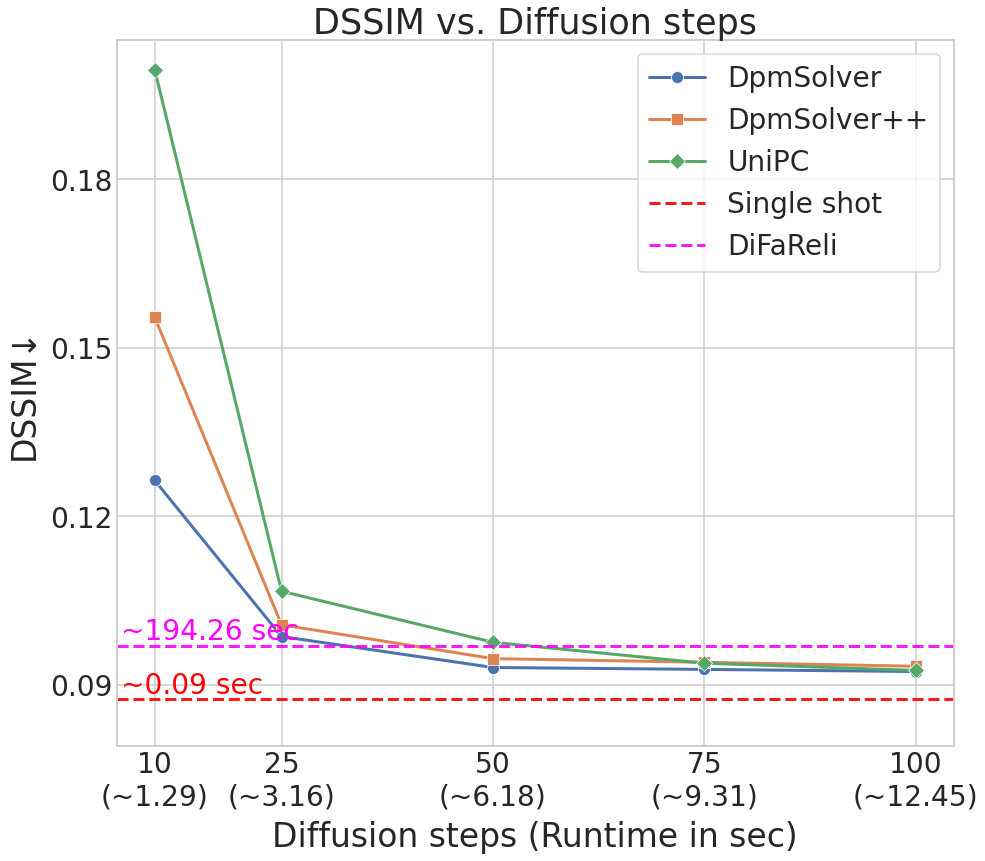

['1.29', '3.16', '6.18', '9.31', '12.45']


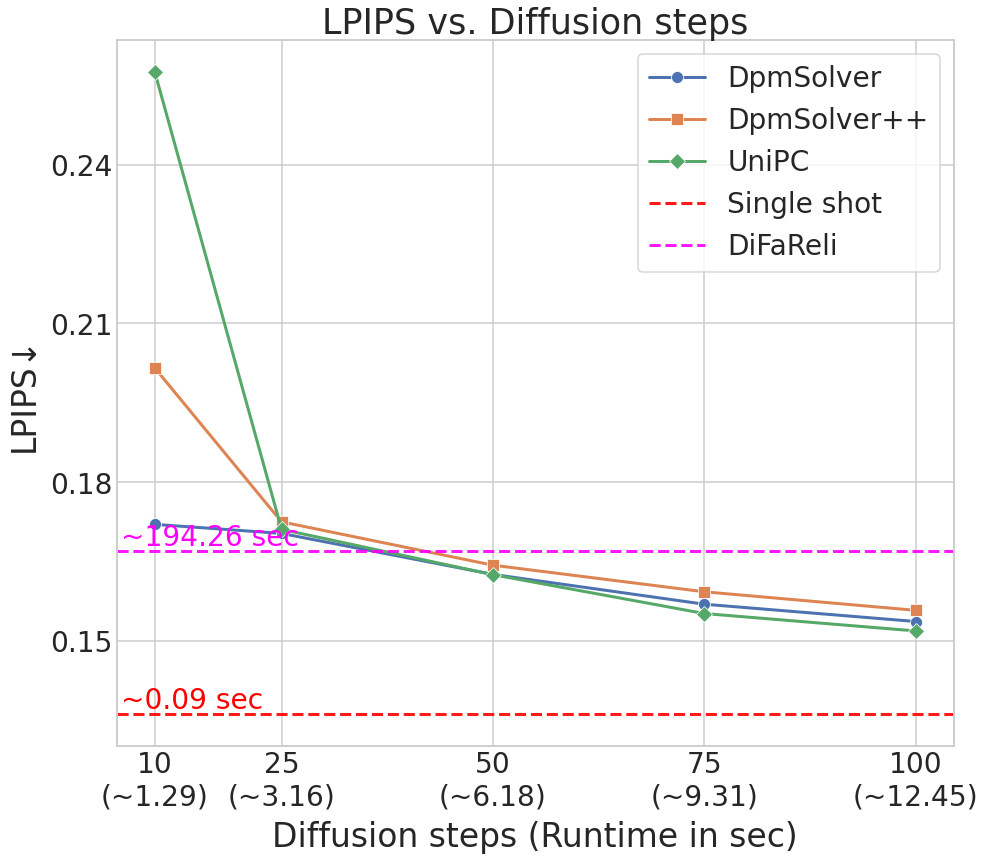

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

# print(score_dict)

def plot(score_dict, metric, solver_name, solver_label, marker=['o', 's', 'D']):
    # Your data
    # Create the plot
    plt.figure(figsize=(8, 6))
    plt.rcParams.update({'font.size': 14}) # This affects all text elements
    for i, sn in enumerate(solver_name):
        x = []
        y = []
        running_time = []
        # for steps, error in score_dict[sn]['steps'].keys():
        for steps in plot_step:
            error = score_dict[sn]['steps'][str(steps)]
            x.append(int(steps))
            y.append(float(error[f'mean_{metric}']))

        plt.plot(x, y, marker=marker[i], linestyle='-', label=solver_label[i], linewidth=3, markersize=7)
    

    # Add titles and labels
    plt.title(f'{str.upper(metric)} vs. Diffusion steps')
    plt.xlabel('Diffusion steps\n(Runtime)')
    plt.ylabel(f'{str.upper(metric)}')
    
    plt.xticks(x)
    # plt.xticks(np.arange(0, 125, 25))
    plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=5)) # Adjust `nbins` for y-axis ticks

    # Add the running times as text annotations at each x-tick
    running_times = [2, 3, 4, 5, 6]
    # Get current x-axis tick labels and modify them
    locs, labels = plt.xticks()
    print(locs, labels)
    new_labels = [f"{locs[j]}\n(~{running_times[j]} sec)" for j, label in enumerate(labels)]
    # Set the modified labels
    # plt.xticks(locs, new_labels)#, rotation=45)
    plt.xticks(locs, new_labels, rotation=15)
    
    # Adding single shot
    plt.axhline(y=ours_test_score['ss'][f'mean_{metric}'], color='r', linestyle='--', label='Single shot', linewidth=2, alpha=0.5)
    plt.text(7, ours_test_score['ss'][f'mean_{metric}'], '~0.09 sec', ha='left', va='bottom', color='red')
    
    # Adding DiFaReli's baseline
    plt.axhline(y=ours_test_score['difareli'][f'mean_{metric}'], color='magenta', linestyle='--', label='difareli', linewidth=2, alpha=0.5)
    plt.text(7, ours_test_score['difareli'][f'mean_{metric}'], '~194.29 sec', ha='left', va='bottom', color='magenta')
    
    
    plt.legend()

    # Display the plot
    plt.grid(True)
    plt.show()
    
def plot_seaborn(score_dict, metric, solver_name, solver_label, marker=['o', 's', 'D']):
    # Your data
    plot_step = [10, 25, 50, 75, 100]
    plt.figure(figsize=(15, 13))
    plt.rcParams['font.family'] = 'Calibri'
    sns.set_theme(style="whitegrid")  # Set the theme for Seaborn
    sns.set_context("talk")  # Adjusts the size of the labels, lines, and other elements of the plot# Adjusting text elements
    

    for i, sn in enumerate(solver_name):
        x = []
        y = []
        for steps in plot_step:
            error = score_dict[sn]['steps'][str(steps)]
            x.append(int(steps))
            y.append(float(error[f'mean_{metric}']))

        sns.lineplot(x=x, y=y, marker=marker[i], linestyle='-', label=solver_label[i], linewidth=3, markersize=12)

    # Add titles and labels
    plt.title(f'{str.upper(metric)} vs. Diffusion steps', fontsize=35)
    plt.xlabel('Diffusion steps (Runtime in sec)', fontsize=33, labelpad=10)
    plt.ylabel(f'{str.upper(metric)}↓', fontsize=33, labelpad=10)
    plt.xticks(fontsize=28)  # Adjust X-axis tick label size
    plt.yticks(fontsize=28)  # Adjust Y-axis tick label size

    

    

    plt.tick_params(axis='x', which='major', pad=-5)  # Increase pad for x-axis
    plt.tick_params(axis='y', which='major', pad=-5)  # Increase pad for y-axis
    if metric == 'dssim':
        current_yticks_values, current_yticks_labels = plt.yticks()
        plt.ylim(bottom=current_yticks_values[0] - 0.001)
    
    # current_yticks_values = list(np.array(current_yticks_values) + 0.001)  # Adjust Y-axis tick values
    # plt.yticks(current_yticks_values, [f"{y:.4f}" for y in current_yticks_values])  # Adjust Y-axis tick labels


    runtime_list = [f"{time['mean_runtime']:.2f}" for step, time in runtime_dict.items()]
    print(runtime_list)
    plt.xticks(x, [f"{x_val}\n(~{rt})" for x_val, rt in zip(x, runtime_list)])  # Adjust runtime text here
    plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=5))  # Adjust `nbins` for y-axis ticks
    

    # Adding single shot (assuming `ours_test_score` is defined outside this function)
    plt.axhline(y=ours_test_score['ss'][f'mean_{metric}'], color='red', linestyle='--', label='Single shot', linewidth=3, alpha=0.9)
    plt.text(6, ours_test_score['ss'][f'mean_{metric}'], '~0.09 sec', ha='left', va='bottom', color='red', fontsize=28)
    # Adding DiFaReli's baseline
    plt.axhline(y=ours_test_score['difareli'][f'mean_{metric}'], color='magenta', linestyle='--', label='DiFaReli', linewidth=3, alpha=0.9)
    plt.text(6, ours_test_score['difareli'][f'mean_{metric}'], '~194.26 sec', ha='left', va='bottom', color='magenta', fontsize=28)
    

    plt.legend(fontsize=28)  # Adjust legend font size
    plt.show()
    
# plot(score_dict, 'mse', ['dpmsolver', 'dpmsolver++', 'unipc'], ['DpmSolver', 'DpmSolver++', 'UniPC'])
plot_seaborn(score_dict, 'mse', ['dpmsolver', 'dpmsolver++', 'unipc'], ['DpmSolver', 'DpmSolver++', 'UniPC'])
# plot(score_dict, 'dssim', ['dpmsolver', 'dpmsolver++', 'unipc'], ['DpmSolver', 'DpmSolver++', 'UniPC'])
plot_seaborn(score_dict, 'dssim', ['dpmsolver', 'dpmsolver++', 'unipc'], ['DpmSolver', 'DpmSolver++', 'UniPC'])
# plot(score_dict, 'lpips', ['dpmsolver', 'dpmsolver++', 'unipc'], ['DpmSolver', 'DpmSolver++', 'UniPC'])
plot_seaborn(score_dict, 'lpips', ['dpmsolver', 'dpmsolver++', 'unipc'], ['DpmSolver', 'DpmSolver++', 'UniPC'])
